In [2]:
import music21 as m21
import glob
from typing import Iterator
import matplotlib.pyplot as plt
import torch

In [3]:
opuses = []
for i, abc_file_path in enumerate(glob.glob("../data/esac/*.abc")):
    print(i, end=" ")
    try:
        opuses.append(m21.converter.parse(abc_file_path))
    except Exception as ex:
        print(ex)

0 1 2 

KeyboardInterrupt: 

In [3]:
sum(len(opus[1:]) for opus in opuses)

9789

In [4]:
opuses[0][1][1]
# opus.score.part.measure

<music21.stream.Part 0x7f17e382ada0>

In [5]:
def iter_parts(opuses: list[m21.stream.Opus]) -> Iterator[m21.stream.Part]:
    for opus in opuses:
        for score in opus[1:]:
            # yield score[0].localeOfComposition
            for part in score[1:]:
                yield part

part = next(iter_parts(opuses))
# locales = Counter(iter_parts(opuses))
# len(locales)

9714 145


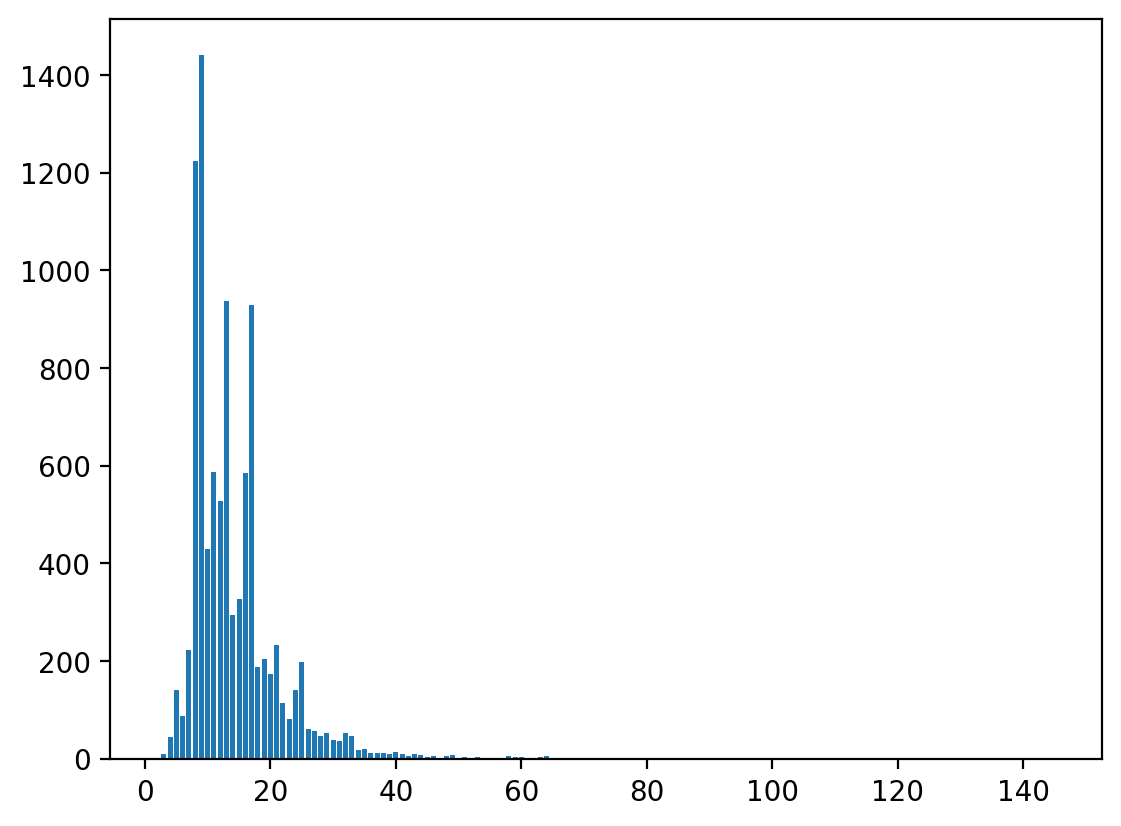

In [6]:
from collections import Counter

len_count = Counter((len(part) for part in iter_parts(opuses) if isinstance(part[0], m21.stream.Measure)))
plt.bar(len_count.keys(), len_count.values())
print(len_count.total(), max(len_count))

In [7]:
measureless_idx = {i for i, part in enumerate(iter_parts(opuses)) if not isinstance(part[0], m21.stream.Measure)}
measureless_parts = [part for i, part in enumerate(iter_parts(opuses)) if i in measureless_idx]
parts = [part for i, part in enumerate(iter_parts(opuses)) if i not in measureless_idx]

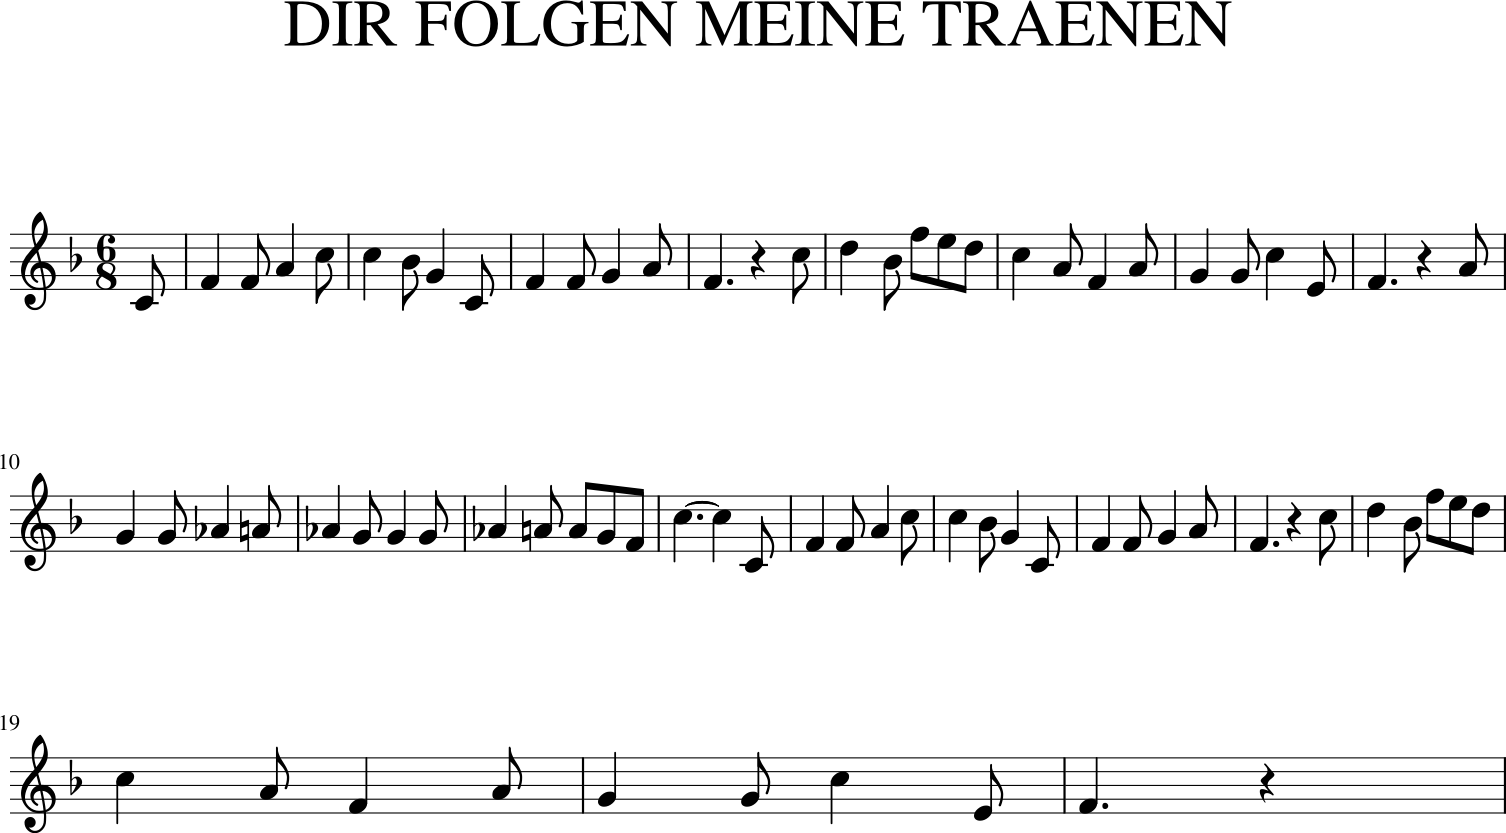

In [72]:
# for sth in measureless_parts[1]:
#     print(sth, sth.duration.quarterLength)
# m21.analysis.reduction.PartReduction(measureless_parts[1])
idx = 1800
parts[idx].show()
sp = m21.midi.realtime.StreamPlayer(parts[idx])
sp.play()

In [8]:
parts_bar16 = [part for part in parts if max(len(m) for m in part) <= 16]
len(parts_bar16), len(parts)

(9683, 9714)

In [9]:
def notes_and_rests(stream: m21.stream.Part | m21.stream.Measure) -> Iterator[m21.note.Note|m21.note.Rest]:
    if isinstance(stream, m21.stream.Measure):
        stream = [stream]

    for bar in stream:
        for symbol in bar:
            if isinstance(symbol, m21.note.Note|m21.note.Rest):
                yield symbol

sieved_parts = list(part for part in parts_bar16 if all(note.duration.quarterLength < 100 for note in notes_and_rests(part)))
quaterLengths = {note.duration.quarterLength for part in sieved_parts for note in notes_and_rests(part)}

In [10]:
idx_2_quater_lens = [None] + sorted(quaterLengths)
quater_lens_2_idx = {q: i for i, q in enumerate(idx_2_quater_lens)}

In [11]:
quater_lens_2_idx

{None: 0,
 Fraction(1, 12): 1,
 0.125: 2,
 Fraction(1, 6): 3,
 0.25: 4,
 Fraction(1, 3): 5,
 0.375: 6,
 0.5: 7,
 Fraction(2, 3): 8,
 0.75: 9,
 1.0: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 2.0: 13,
 2.5: 14,
 Fraction(8, 3): 15,
 3.0: 16,
 3.5: 17,
 4.0: 18,
 6.0: 19,
 7.0: 20,
 8.0: 21,
 9.0: 22,
 12.0: 23,
 16.0: 24}

In [24]:
import numpy as np

def encode_note(note: m21.note.Note|m21.note.Rest) -> tuple[int, int]:
    REST_CODE = 1
    encoded_duration = quater_lens_2_idx[note.duration.quarterLength]
    if isinstance(note, m21.note.Rest):
        return REST_CODE, encoded_duration
    return note.pitch.midi, encoded_duration

def encode_measure(measure: m21.stream.Measure) -> np.ndarray:
    return tuple(encode_note(note) for note in notes_and_rests(measure))

def encode_part(part: m21.stream.Part) -> tuple[np.ndarray]:
    return tuple(encode_measure(m) for m in part)

In [25]:
encoded_parts = [encode_part(p) for p in sieved_parts]

<BarContainer object of 80 artists>

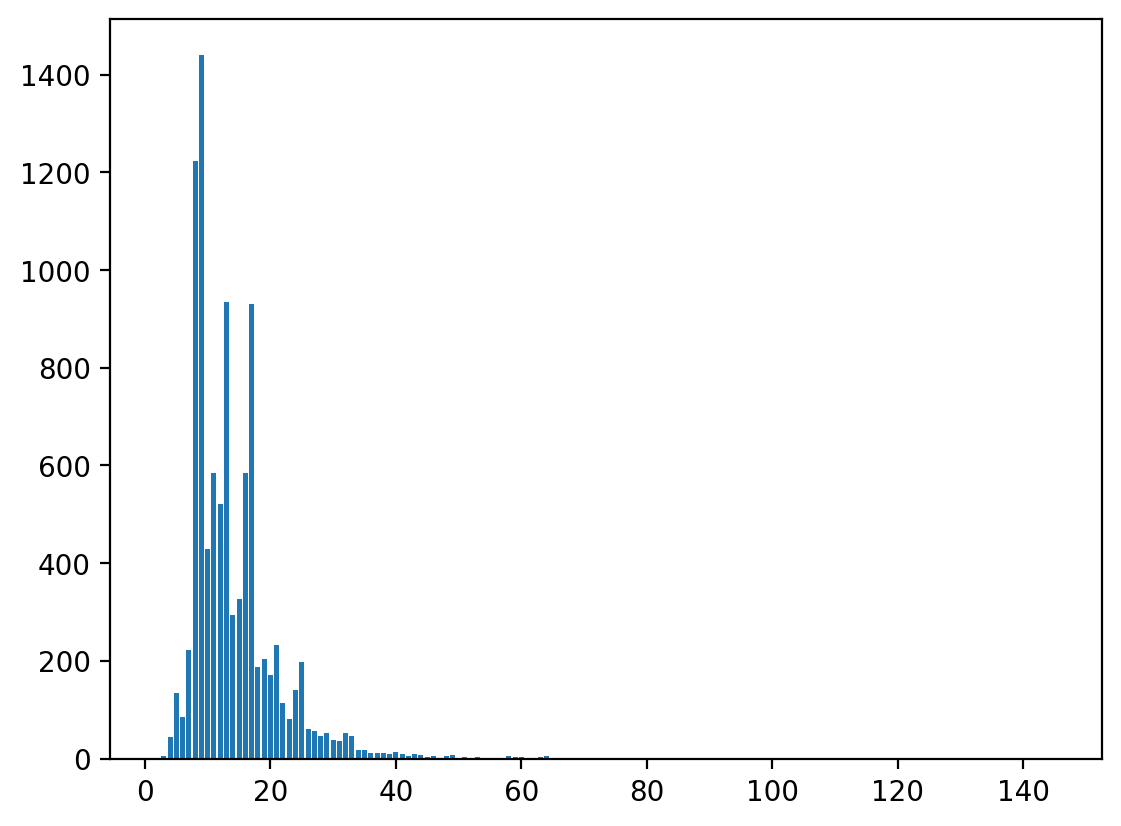

In [26]:
count = Counter(len(part) for part in encoded_parts)
plt.bar(count.keys(), count.values())

Counter({1: 12253,
         4: 41121,
         5: 17046,
         3: 30066,
         6: 11881,
         2: 20996,
         7: 3042,
         8: 1401,
         9: 242,
         11: 81,
         13: 27,
         12: 40,
         14: 13,
         10: 123,
         16: 3,
         15: 4})

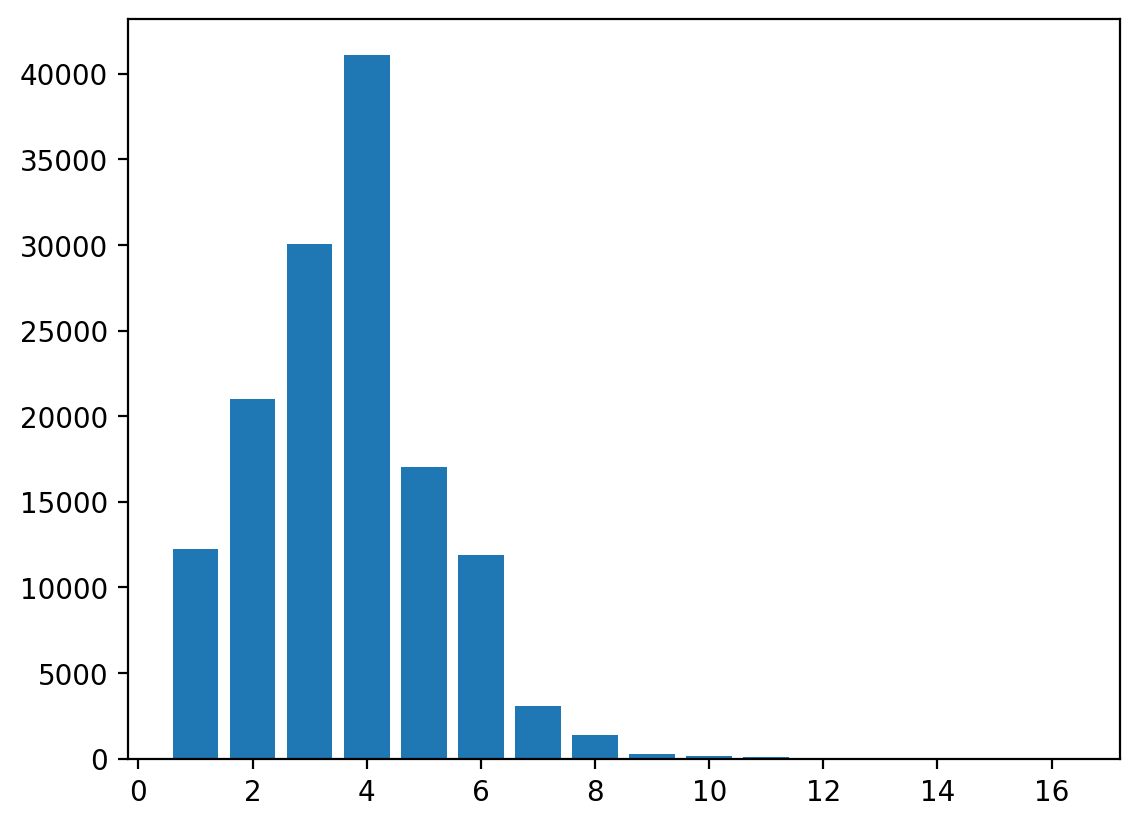

In [28]:
count = Counter(len(m) for part in encoded_parts for m in part)
plt.bar(count.keys(), count.values())
count

(48, 94, 47)

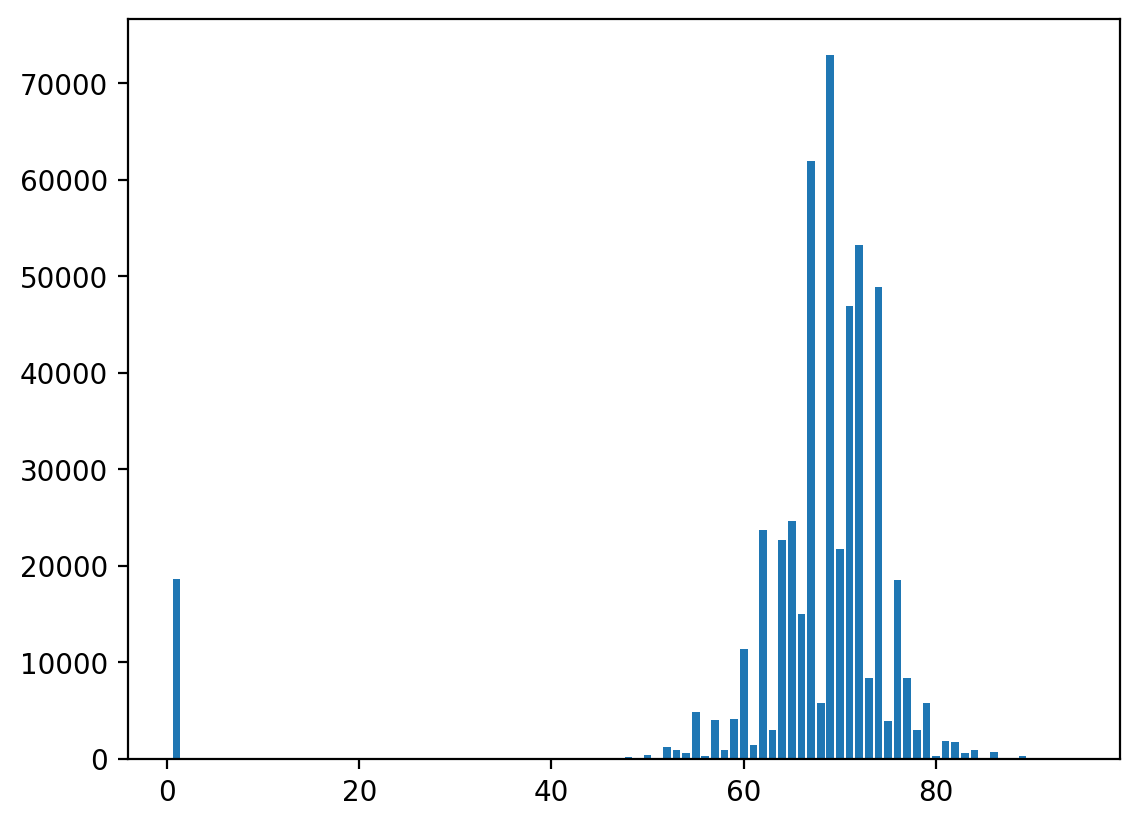

In [30]:
PITCH = 0
DURATION = 1

encoded_parts
min_pitch = min(note[PITCH] for part in encoded_parts for bar in part for note in bar if note[PITCH] > 1)
max_pitch = max(note[PITCH] for part in encoded_parts for bar in part for note in bar if note[PITCH] > 1)
count = Counter(note[PITCH] for part in encoded_parts for bar in part for note in bar)
plt.bar(count.keys(), count.values())
pitch_span = max_pitch - min_pitch + 1
min_pitch, max_pitch, pitch_span

Counter({7: 235466,
         10: 132366,
         12: 16068,
         4: 55868,
         3: 376,
         9: 12821,
         6: 225,
         2: 481,
         13: 35162,
         16: 2461,
         5: 1913,
         8: 78,
         18: 8432,
         11: 55,
         22: 1,
         1: 9,
         19: 578,
         21: 891,
         24: 19,
         23: 79,
         15: 12,
         17: 2,
         14: 1,
         20: 1})

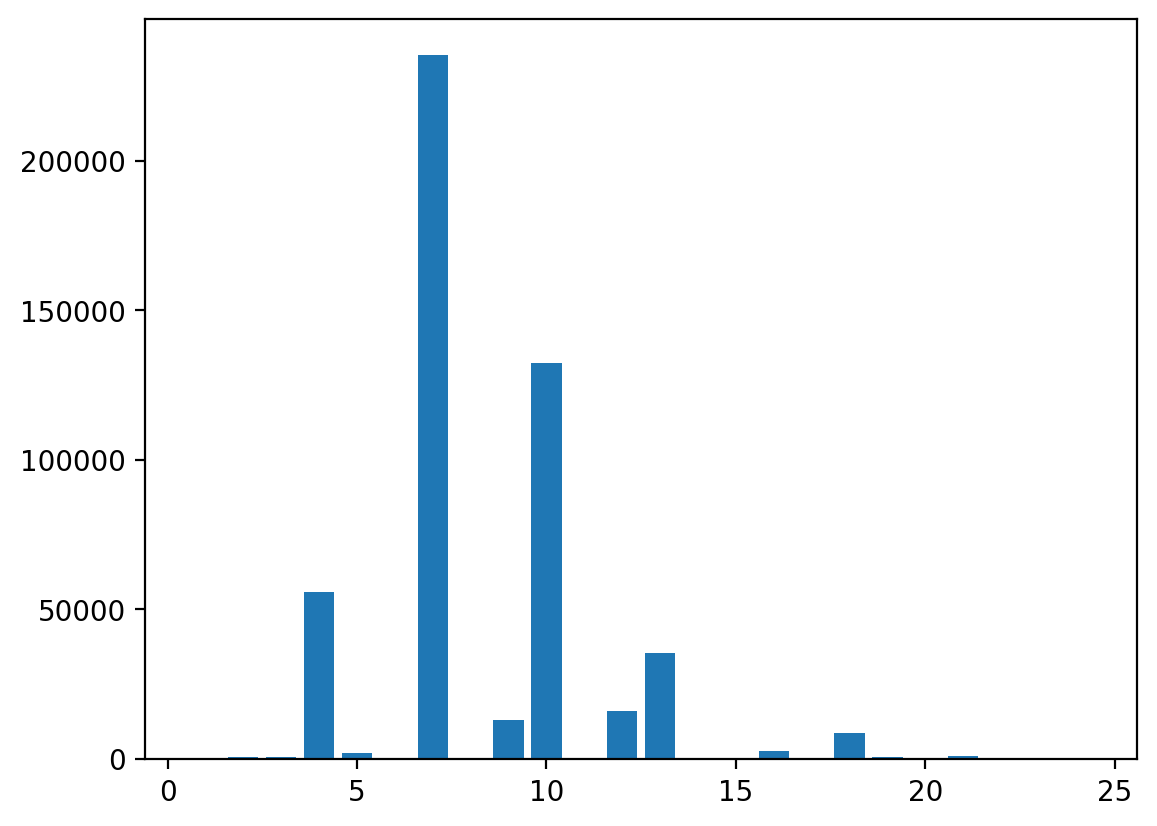

In [31]:
count = Counter(note[DURATION] for part in encoded_parts for bar in part for note in bar)
plt.bar(count.keys(), count.values())
count

In [32]:
len(encoded_parts)

9682

In [33]:
encoded_parts[0]

(((67, 7),),
 ((60, 10), (62, 7), (63, 10), (65, 7)),
 ((67, 10), (67, 7), (65, 10), (67, 7)),
 ((68, 10), (67, 7), (65, 7), (63, 7), (65, 7)),
 ((67, 12), (67, 10), (67, 7)),
 ((67, 7), (68, 7), (70, 7), (71, 7), (69, 7), (67, 7)),
 ((67, 10), (65, 7), (65, 10), (65, 7)),
 ((63, 7), (65, 7), (67, 7), (67, 7), (65, 7), (64, 7)),
 ((63, 10), (62, 7), (62, 10), (67, 7)),
 ((67, 7), (65, 7), (63, 7), (62, 7), (60, 7), (59, 7)),
 ((60, 12), (60, 10)))

In [34]:
import numpy as np

np.save("../data/measures/esac_parts.npy", np.array(encoded_parts, dtype=object), allow_pickle=True)

In [383]:
set_of_measure_pitches = set()


def diff_iter(iterable):
    if len(iterable) < 2:
        yield 0
        return
    iterator = iter(iterable)
    prev = next(iterator)
    for nxt in iterator:
        yield nxt - prev
        prev = nxt

for measure_len in range(2, 9):
    filter = lambda m: len(m) == measure_len
    set_of_measure_pitch_diffs = {tuple(diff_iter(m)) for m in set_of_measure_pitches if filter(m) }
    print(measure_len, len(set_of_measure_pitch_diffs), len(list(m for m in set_of_measure_pitches if filter(m) )))

2 105 737
3 1170 4408
4 4446 12235
5 7149 13801
6 6647 9930
7 3151 3629
8 1417 1514


In [400]:
import numpy as np
np_measures = [np.array(m) for m in set_of_measures]
np_measures[5]
np.save("../data/measures/esac.npy", np.array(np_measures, dtype=object), allow_pickle=True)

In [406]:
np_measures = np.load("../data/measures/esac.npy", allow_pickle=True)

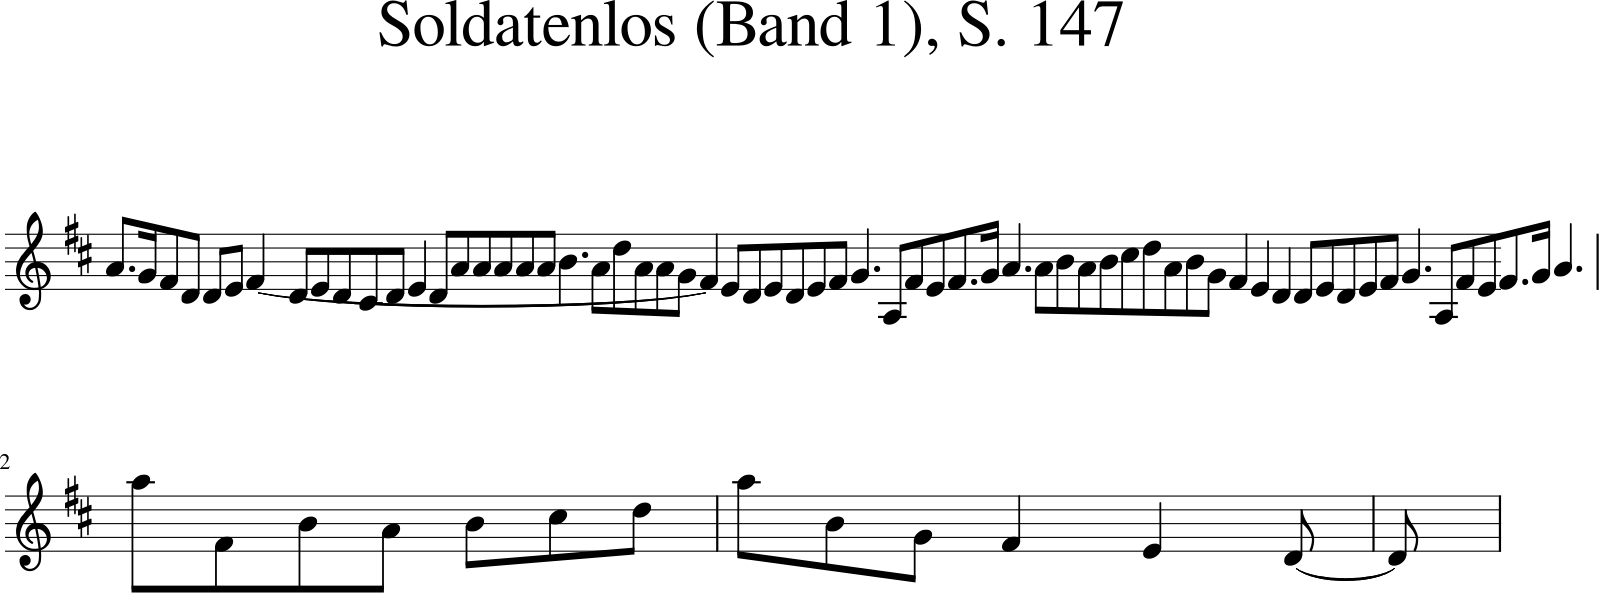

In [194]:
opuses[2][48].show()
# opuses[2][48]

In [155]:
for sth in opuses[30][15][1]:
    print(sth, sth.quarterLength)

<music21.clef.TrebleClef> 0.0
D major 0.0
<music21.note.Note D> 1.0
<music21.note.Note F> 0.5
<music21.note.Note E> 0.25
<music21.note.Note F#> 0.25
<music21.note.Note D> 0.25
<music21.note.Note E> 0.25
<music21.note.Note C> 0.125
<music21.note.Note D> 0.25
<music21.note.Note B-> 0.25
<music21.note.Note C#> 0.25
<music21.note.Note A> 0.25
<music21.note.Note C#> 0.25
<music21.note.Note A> 0.25
<music21.note.Note B> 0.25
<music21.note.Note G> 0.5
<music21.note.Note C#> 0.5
<music21.note.Note B> 0.5
<music21.note.Note C#> 0.5
<music21.note.Note D> 0.25
<music21.note.Note E> 0.25
<music21.note.Note D> 0.25
<music21.note.Note E> 0.25
<music21.note.Note F#> 0.25
<music21.note.Note G> 0.25
<music21.note.Note F#> 0.25
<music21.note.Note E> 0.25
<music21.note.Note D> 1.0
<music21.note.Note B> 0.25
<music21.note.Note C#> 0.25
<music21.note.Note D> 0.75
<music21.note.Note C#> 0.25
<music21.note.Note B> 0.25
<music21.note.Note C#> 0.25
<music21.note.Note D> 0.5
<music21.note.Note G> 0.5
<music21.n

In [ ]:
for s in score.parts[0][0]:
    if isinstance(s, m21.note.Note):
        print(s.duration)
    print(s)

<music21.clef.TrebleClef>
C major
<music21.meter.TimeSignature 2/4>
<music21.duration.Duration 1.0>
<music21.note.Note D>
<music21.duration.Duration 0.5>
<music21.note.Note A>
<music21.duration.Duration 0.5>
<music21.note.Note C>
